# Assignment Overview - Alzheimer Brain Images Multi-series Classification
For my final project, I have chosen the multiclass problem of classifying Alzheimer brain images. The goal is to determine if an MRI image of a brain is mild demented, moderate demented, non-demented, or very mild demented. I use Convolutional Neural Networks to perform this multiclass classification task.

# Data Description
The dataset is initially split into train and test sets. There are four classes: mild demented, moderate demented, non-demented, and very mild demented. Each image in the data is an MRI scan of one of these classes. However, the data is imbalanced. Mild and moderate demented have significantly less samples than non-demented and very mild demented. In the test data there are 179 mild demented, 12 moderate demented, 640 non-demented, and 448 very mild demented. In the train data there are 717 mild demented, 52 moderate demented, 2560 non-demented, and 1792 very mild demented. In my high level analysis, each image seems to have a standardized size and placement.

# Method Summary
Normally, I would like to use some kind of hyperparameter tuning. However, I am resource restrained for this project. My Google Colab has been usage throttled and have to result to using Kaggle Notebooks, which is having issues using GPU's and times out after an hour or so. Therefore I need to keep my processing times to under an hour. Because of this, I will be attempting small changes to models, observing the results, and then deciding how to proceed iteratively instead of using something like GridSearchCV which may take hours to compute.
  + Data preparation
    + Import libraries
    + Resample data into train/validation/test sets
    + Preprocess images
    + View sample images
  + Create base model
    + Train InceptionV3 model with all layers frozen
    + Using Functional API
    + Evaluate model
  + Model improvement
    + Try different methods such as unfreezing layers, class weights, and pooling methods

#### Import Libraries

In [1]:
# %tensorflow_version 2.x
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import backend, models, layers, optimizers, regularizers, metrics
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.utils import plot_model


from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from PIL import Image

import shutil

np.random.seed(0)
tf.random.set_seed(0)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

# Import/Preprocess Data

In [2]:
base_dir = '../input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset'
training = (base_dir + '/train')
test = (base_dir + '/test')

In [3]:
img_size = [250, 250]
epochs = 50

In [4]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(
    rescale=1./255
)

train_generator = train_datagen.flow_from_directory(
    training,
    target_size=(250, 250),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    color_mode='rgb'
)

validation_generator = train_datagen.flow_from_directory(
    training,
    target_size=(250, 250),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    color_mode='rgb'
)

test_generator = train_datagen.flow_from_directory(
    test,
    target_size=(250, 250),
    batch_size=32,
    class_mode='categorical',
    color_mode='rgb'
)

class_names = ['MildDementia', 'ModerateDementia', 'NonDementia', 'VeryMildDementia']
train_generator.class_names = class_names
validation_generator.class_names = class_names
test_generator.class_names = class_names

steps_per_epoch = train_generator.n // train_generator.batch_size
print('steps per epoch: ',steps_per_epoch)

Found 4098 images belonging to 4 classes.
Found 1023 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.
steps per epoch:  128


# View Sample Images

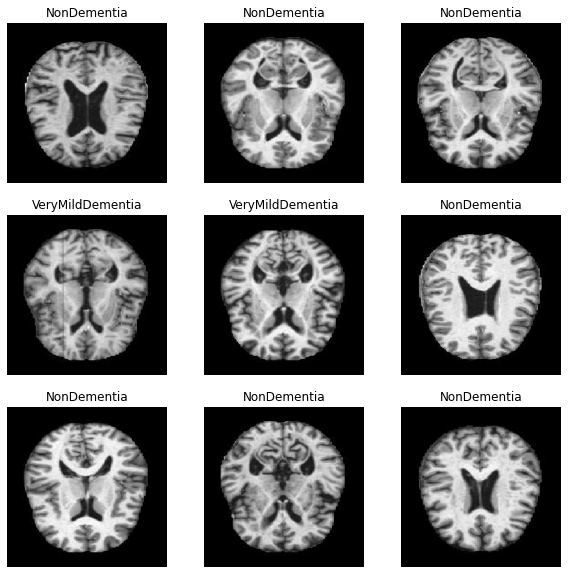

In [5]:
for images, labels in train_generator:
  plt.figure(figsize=(10,10))
  for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.imshow(images[i])
    class_name = train_generator.class_names[np.where(labels[i] == 1)[0][0]]
    plt.title(class_name)
    plt.axis('off')
  plt.show()
  break

# Model Summary
The InceptionV3 model is fairly complicated. The general structure will stay the same throughout this project discounting some frozen/unfrozen layers and maybe a Dense layer with some regularization. The output layer predicts the four previously mentioned classes and uses the softmax activation function. When compiling the model I use the adam optimizer, categorical crossentropy loss, and AUC as a metric. The model is fitted on the train data and validated on the validation data. Early stopping is being used which monitors the validation AUC.

# Base Model: InceptionV3 + All Layers Frozen

2022-12-06 18:46:09.946507: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-06 18:46:09.947577: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-06 18:46:10.251838: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-06 18:46:10.252805: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-06 18:46:10.253604: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

87924736/87910968 [==============================] - 1s 0us/step


2022-12-06 18:46:18.560622: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2022-12-06 18:46:24.418852: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


128/128 [==============================] - 65s 387ms/step - loss: 16.1258 - auc: 0.7355 - val_loss: 15.3149 - val_auc: 0.6888
Epoch 2/50
128/128 [==============================] - 16s 121ms/step - loss: 3.4041 - auc: 0.8545 - val_loss: 11.9713 - val_auc: 0.6935
Epoch 3/50
128/128 [==============================] - 15s 119ms/step - loss: 1.8021 - auc: 0.9082 - val_loss: 3.8092 - val_auc: 0.8024
Epoch 4/50
128/128 [==============================] - 17s 129ms/step - loss: 0.8453 - auc: 0.9508 - val_loss: 4.3702 - val_auc: 0.7848
Epoch 5/50
128/128 [==============================] - 16s 126ms/step - loss: 0.8693 - auc: 0.9526 - val_loss: 6.9686 - val_auc: 0.6989
Epoch 6/50
128/128 [==============================] - 17s 129ms/step - loss: 0.5148 - auc: 0.9757 - val_loss: 3.4483 - val_auc: 0.7874
Epoch 7/50
128/128 [==============================] - 16s 122ms/step - loss: 0.0462 - auc: 0.9986 - val_loss: 3.3098 - val_auc: 0.7813
Epoch 8/50
128/128 [==============================] - 16s 124ms

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


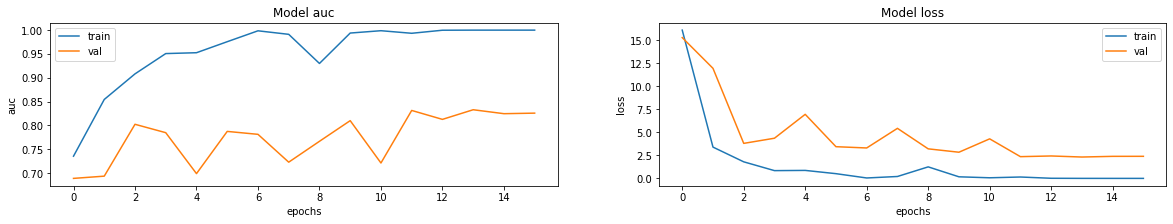

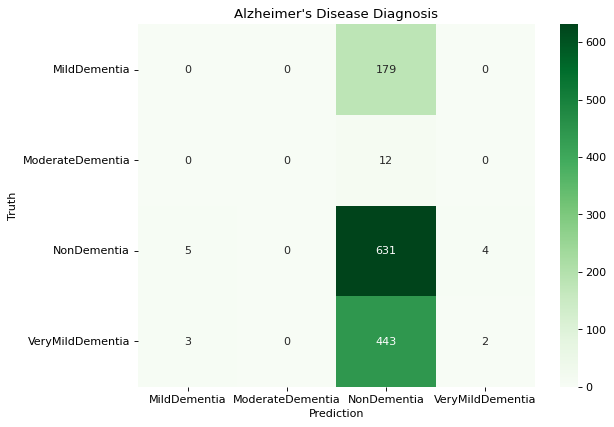

In [6]:
backend.clear_session()
inception_base = InceptionV3(
    weights = 'imagenet', 
    include_top = False,
    input_shape = (*img_size, 3)
    )

inception_base.trainable = False

visible = layers.Input(shape=(250,250,3), name='input')
x = inception_base(visible)

x = layers.Flatten()(x)
x = layers.Dense(512, activation = 'relu')(x)

output = layers.Dense(4, activation='softmax', name='output')(x)

model = Model(inputs=visible, outputs=output)

model.compile(optimizer = 'adam',
               loss = 'categorical_crossentropy',
               metrics = [metrics.AUC(name='auc')]
             )

history = model.fit( 
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=validation_generator,
    verbose = 1,
    callbacks=[
               EarlyStopping(
                   monitor='val_auc',
                   patience=15,
                   restore_best_weights = True
                   )
               ]
            )

fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()
for i, met in enumerate(['auc', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

test_loss, test_auc = model.evaluate(test_generator)
print()
print('test_auc:', test_auc)

y_prob = model.predict(test_generator)
y_pred = y_prob.argmax(axis=-1)
y_actual = test_generator.classes

print()
print(classification_report(y_actual, y_pred, target_names=class_names))

cm = confusion_matrix(y_actual, y_pred)
plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
ax = sns.heatmap(cm, cmap='Greens', annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.title('Alzheimer\'s Disease Diagnosis')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)

### Results
This base model did not do very well. It seems to want to classify everything as very mild dementia. The AUC is pretty low because of the large number of non-dementia majority class that were missclassified.

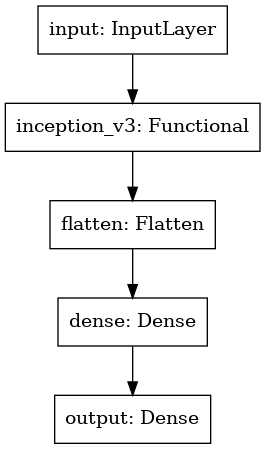

In [7]:
plot_model(model)

# Data Augmentation

In [8]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=5,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.1,
)

test_datagen = ImageDataGenerator(
    rescale=1./255
)

train_generator = train_datagen.flow_from_directory(
    training,
    target_size=(250, 250),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    color_mode='rgb'
)

validation_generator = train_datagen.flow_from_directory(
    training,
    target_size=(250, 250),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    color_mode='rgb'
)

test_generator = train_datagen.flow_from_directory(
    test,
    target_size=(250, 250),
    batch_size=32,
    class_mode='categorical',
    color_mode='rgb'
)

class_names = ['MildDementia', 'ModerateDementia', 'NonDementia', 'VeryMildDementia']
train_generator.class_names = class_names
validation_generator.class_names = class_names
test_generator.class_names = class_names

steps_per_epoch = train_generator.n // train_generator.batch_size
print('steps per epoch: ',steps_per_epoch)

Found 4098 images belonging to 4 classes.
Found 1023 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.
steps per epoch:  128


# Previous + Data Augmentation + Dropout + Dense 1024
Given the last model locked onto a single class, I am going to add Dropout layers and increase the Dense layer to 1024 in an attempt to make it differentiate classes better.

Epoch 1/50
128/128 [==============================] - 85s 634ms/step - loss: 13.8756 - auc: 0.7034 - val_loss: 1.0151 - val_auc: 0.8021
Epoch 2/50
128/128 [==============================] - 78s 606ms/step - loss: 1.0252 - auc: 0.7997 - val_loss: 0.9901 - val_auc: 0.8070
Epoch 3/50
128/128 [==============================] - 78s 609ms/step - loss: 1.0255 - auc: 0.8031 - val_loss: 0.9613 - val_auc: 0.8090
Epoch 4/50
128/128 [==============================] - 78s 611ms/step - loss: 1.0020 - auc: 0.8066 - val_loss: 1.0020 - val_auc: 0.8144
Epoch 5/50
128/128 [==============================] - 79s 615ms/step - loss: 1.0204 - auc: 0.8014 - val_loss: 0.9906 - val_auc: 0.8177
Epoch 6/50
128/128 [==============================] - 78s 608ms/step - loss: 0.9931 - auc: 0.8134 - val_loss: 0.9446 - val_auc: 0.8243
Epoch 7/50
128/128 [==============================] - 79s 614ms/step - loss: 0.9996 - auc: 0.8087 - val_loss: 0.9767 - val_auc: 0.8054
Epoch 8/50
128/128 [==============================] - 

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


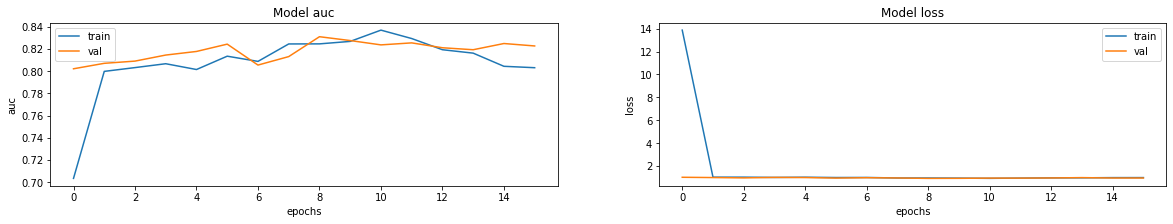

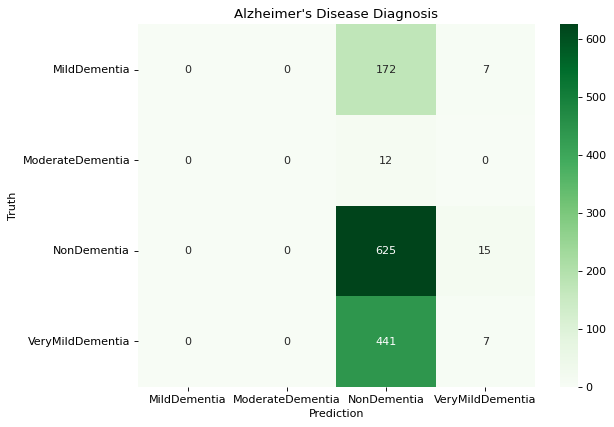

In [9]:
dropout = 0.5

backend.clear_session()
inception_base = InceptionV3(
    weights = 'imagenet', 
    include_top = False,
    input_shape = (*img_size, 3),
    )

inception_base.trainable = False

visible = layers.Input(shape=(250,250,3), name='input')
x = inception_base(visible)
x = layers.Dropout(dropout)(x)

x = layers.Flatten()(x)
x = layers.Dense(1024, activation = 'relu')(x)
x = layers.Dropout(dropout + 0.1)(x)

output = layers.Dense(4, activation='softmax', name='output')(x)

model = Model(inputs=visible, outputs=output)

model.compile(optimizer = 'adam',
               loss = 'categorical_crossentropy',
               metrics = [metrics.AUC(name='auc')]
             )

history = model.fit( 
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=validation_generator,
    verbose = 1,
    callbacks=[
               EarlyStopping(
                   monitor='val_auc',
                   patience=15,
                   restore_best_weights = True
                   )
               ]
            )

fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()
for i, met in enumerate(['auc', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

test_loss, test_auc = model.evaluate(test_generator)
print()
print('test_auc:', test_auc)

y_prob = model.predict(test_generator)
y_pred = y_prob.argmax(axis=-1)
y_actual = test_generator.classes

print()
print(classification_report(y_actual, y_pred, target_names=class_names))

cm = confusion_matrix(y_actual, y_pred)
plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
ax = sns.heatmap(cm, cmap='Greens', annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.title('Alzheimer\'s Disease Diagnosis')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)

### Results
This model has a much improved AUC, but now it is essentially a non-dementia predictive model. Out of the four classes, that is probably the least useful to predict when trying to help with Alzheimer's.

# Dealing With Imbalanced Data
This dataset is very imbalanced. Ideally, I would get more legit data samples to even it out. Given this is out of scope for this exercise, two other options are upsampling/downsampling or using class weights. I don't think upsampling/downsampling is a good idea most of the time because most data in real life is imbalanced, and it sort of teaches you to not deal with the issue very well. Therefore, I am going to utilize class weights for this project.

In [10]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes), 
    y=train_generator.classes
)
train_class_weights = dict(enumerate(class_weights))
train_class_weights

{0: 1.7848432055749128,
 1: 24.392857142857142,
 2: 0.500244140625,
 3: 0.7144351464435147}

# Previous + Class Weights

Epoch 1/50
128/128 [==============================] - 84s 626ms/step - loss: 28.0505 - auc: 0.5922 - val_loss: 1.5766 - val_auc: 0.4679
Epoch 2/50
128/128 [==============================] - 79s 614ms/step - loss: 1.4576 - auc: 0.5397 - val_loss: 1.2748 - val_auc: 0.6509
Epoch 3/50
128/128 [==============================] - 79s 615ms/step - loss: 1.3178 - auc: 0.5345 - val_loss: 1.2901 - val_auc: 0.6587
Epoch 4/50
128/128 [==============================] - 77s 602ms/step - loss: 1.3242 - auc: 0.5736 - val_loss: 1.3720 - val_auc: 0.4846
Epoch 5/50
128/128 [==============================] - 79s 618ms/step - loss: 1.3311 - auc: 0.3789 - val_loss: 1.4396 - val_auc: 0.4194
Epoch 6/50
128/128 [==============================] - 79s 616ms/step - loss: 1.3032 - auc: 0.5560 - val_loss: 1.3897 - val_auc: 0.5187
Epoch 7/50
128/128 [==============================] - 79s 617ms/step - loss: 1.2256 - auc: 0.6104 - val_loss: 1.3547 - val_auc: 0.6995
Epoch 8/50
128/128 [==============================] - 

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


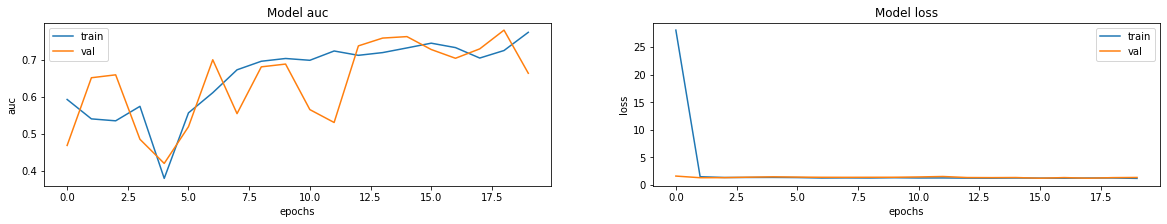

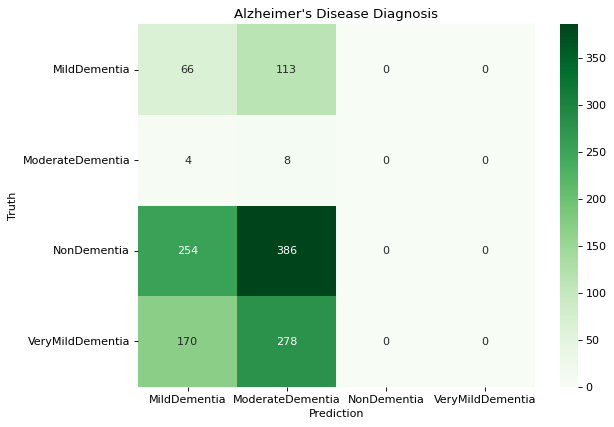

In [11]:
dropout = 0.5

backend.clear_session()
inception_base = InceptionV3(
    weights = 'imagenet', 
    include_top = False,
    input_shape = (*img_size, 3),
    )

inception_base.trainable = False

visible = layers.Input(shape=(250,250,3), name='input')
x = inception_base(visible)
x = layers.Dropout(dropout)(x)

x = layers.Flatten()(x)
x = layers.Dense(1024, activation = 'relu')(x)
x = layers.Dropout(dropout + 0.1)(x)

output = layers.Dense(4, activation='softmax', name='output')(x)

model = Model(inputs=visible, outputs=output)

model.compile(optimizer = 'adam',
               loss = 'categorical_crossentropy',
               metrics = [metrics.AUC(name='auc')]
             )

history = model.fit( 
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=validation_generator,
    verbose = 1,
    class_weight=train_class_weights,
    callbacks=[
               EarlyStopping(
                   monitor='val_auc',
                   patience=15,
                   restore_best_weights = True
                   )
               ]
            )

fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()
for i, met in enumerate(['auc', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

test_loss, test_auc = model.evaluate(test_generator)
print()
print('test_auc:', test_auc)

y_prob = model.predict(test_generator)
y_pred = y_prob.argmax(axis=-1)
y_actual = test_generator.classes

print()
print(classification_report(y_actual, y_pred, target_names=class_names))

cm = confusion_matrix(y_actual, y_pred)
plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
ax = sns.heatmap(cm, cmap='Greens', annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.title('Alzheimer\'s Disease Diagnosis')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)

### Results
This data is very imbalanced which gives very skewed class weights. Without class weights the model essentially predicts non-dementia and very mild dementia. The skewed class weights tries to force it to predict the minor classes and causes terrible performance. It does predict a few of the minor classes correctly but this problem won't be solved with class weights. I really need more data to support the minor classes. I will not be continuing with class weights.

# InceptionV3 + All Layers Frozen + Data Augmentation + Dropout + Dense 1024 + Batch Normalization
Reverting to the model prior to trying class weights, I am going to add Batch Normalization. Hopefully this will allow the model to predict more than one class effectively.

Epoch 1/50
128/128 [==============================] - 85s 633ms/step - loss: 1.5409 - auc: 0.7578 - val_loss: 1.5275 - val_auc: 0.6515
Epoch 2/50
128/128 [==============================] - 78s 610ms/step - loss: 0.8965 - auc: 0.8713 - val_loss: 1.4919 - val_auc: 0.7306
Epoch 3/50
128/128 [==============================] - 79s 614ms/step - loss: 0.7790 - auc: 0.8979 - val_loss: 1.6082 - val_auc: 0.7734
Epoch 4/50
128/128 [==============================] - 79s 616ms/step - loss: 0.7102 - auc: 0.9122 - val_loss: 1.1557 - val_auc: 0.8010
Epoch 5/50
128/128 [==============================] - 78s 611ms/step - loss: 0.6887 - auc: 0.9172 - val_loss: 1.2018 - val_auc: 0.7983
Epoch 6/50
128/128 [==============================] - 78s 613ms/step - loss: 0.6399 - auc: 0.9266 - val_loss: 1.2392 - val_auc: 0.8027
Epoch 7/50
128/128 [==============================] - 78s 608ms/step - loss: 0.6074 - auc: 0.9338 - val_loss: 1.1790 - val_auc: 0.7995
Epoch 8/50
128/128 [==============================] - 7

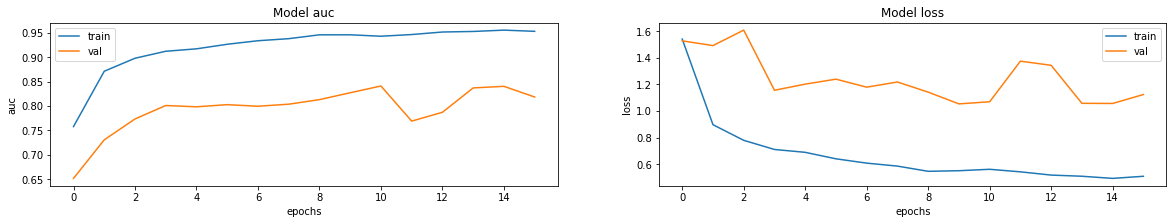

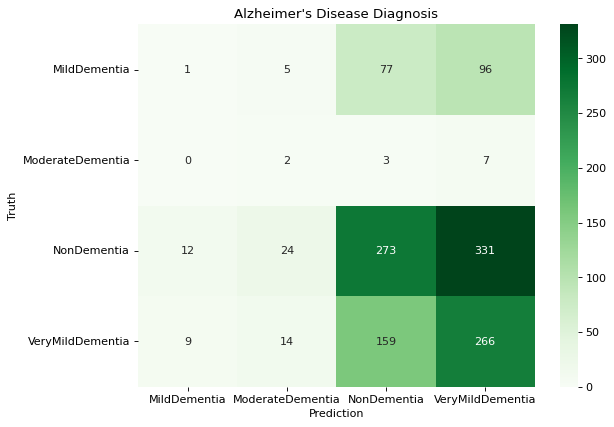

In [12]:
dropout = 0.5

backend.clear_session()
inception_base = InceptionV3(
    weights = 'imagenet', 
    include_top = False,
    input_shape = (*img_size, 3),
    )

inception_base.trainable = False

visible = layers.Input(shape=(250,250,3), name='input')
x = inception_base(visible)
x = layers.BatchNormalization()(x)
x = layers.Dropout(dropout)(x)

x = layers.Flatten()(x)
x = layers.Dense(1024, activation = 'relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(dropout + 0.1)(x)

output = layers.Dense(4, activation='softmax', name='output')(x)

model = Model(inputs=visible, outputs=output)

model.compile(optimizer = 'adam',
               loss = 'categorical_crossentropy',
               metrics = [metrics.AUC(name='auc')]
             )

history = model.fit( 
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=validation_generator,
    verbose = 1,
    callbacks=[
               EarlyStopping(
                   monitor='val_auc',
                   patience=15,
                   restore_best_weights = True
                   )
               ]
            )

fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()
for i, met in enumerate(['auc', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

test_loss, test_auc = model.evaluate(test_generator)
print()
print('test_auc:', test_auc)

y_prob = model.predict(test_generator)
y_pred = y_prob.argmax(axis=-1)
y_actual = test_generator.classes

print()
print(classification_report(y_actual, y_pred, target_names=class_names))

cm = confusion_matrix(y_actual, y_pred)
plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
ax = sns.heatmap(cm, cmap='Greens', annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.title('Alzheimer\'s Disease Diagnosis')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)

### Results
Adding batch normalization did improve the models capability to predict very mild dementia while still doing a decent job predicting non-dementia. It even got a few mild dementia correct. Also, the AUC almost stayed the same.

# InceptionV3(pooling='max') + All Layers Frozen + Data Augmentation + Dropout + Dense 1024
There is an option to change the pooling type within the Inception V3 model. The default is None where the output of the model will be the 4D tensor of the last convolutional block. Max means global max pooling will be used. All previous models have used the default None. This model will use max.

Epoch 1/50
128/128 [==============================] - 83s 620ms/step - loss: 3.0391 - auc: 0.7160 - val_loss: 1.0108 - val_auc: 0.8046
Epoch 2/50
128/128 [==============================] - 78s 612ms/step - loss: 1.0264 - auc: 0.7987 - val_loss: 1.0217 - val_auc: 0.7898
Epoch 3/50
128/128 [==============================] - 78s 607ms/step - loss: 1.0231 - auc: 0.7967 - val_loss: 1.0414 - val_auc: 0.7744
Epoch 4/50
128/128 [==============================] - 78s 611ms/step - loss: 1.0162 - auc: 0.8031 - val_loss: 1.0529 - val_auc: 0.7674
Epoch 5/50
128/128 [==============================] - 94s 732ms/step - loss: 0.9966 - auc: 0.8097 - val_loss: 1.0146 - val_auc: 0.7920
Epoch 6/50
128/128 [==============================] - 79s 615ms/step - loss: 0.9958 - auc: 0.8061 - val_loss: 1.0062 - val_auc: 0.7811
Epoch 7/50
128/128 [==============================] - 79s 618ms/step - loss: 0.9869 - auc: 0.8122 - val_loss: 1.0803 - val_auc: 0.7379
Epoch 8/50
128/128 [==============================] - 8

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


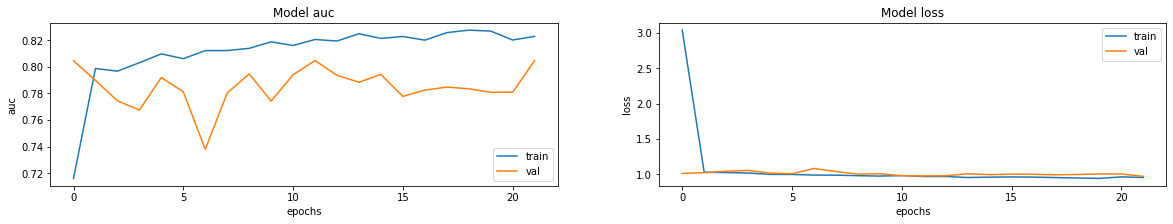

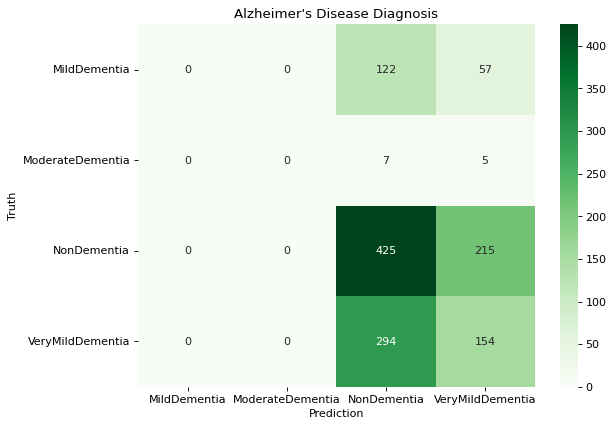

In [13]:
dropout = 0.5

backend.clear_session()
inception_base = InceptionV3(
    weights = 'imagenet', 
    include_top = False,
    input_shape = (*img_size, 3),
    pooling='max'
    )

inception_base.trainable = False

visible = layers.Input(shape=(250,250,3), name='input')
x = inception_base(visible)
x = layers.Dropout(dropout)(x)

x = layers.Flatten()(x)
x = layers.Dense(1024, activation = 'relu')(x)
x = layers.Dropout(dropout + 0.1)(x)

output = layers.Dense(4, activation='softmax', name='output')(x)

model = Model(inputs=visible, outputs=output)

model.compile(optimizer = 'adam',
               loss = 'categorical_crossentropy',
               metrics = [metrics.AUC(name='auc')]
             )

history = model.fit( 
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=validation_generator,
    verbose = 1,
    callbacks=[
               EarlyStopping(
                   monitor='val_auc',
                   patience=15,
                   restore_best_weights = True
                   )
               ]
            )

fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()
for i, met in enumerate(['auc', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

test_loss, test_auc = model.evaluate(test_generator)
print()
print('test_auc:', test_auc)

y_prob = model.predict(test_generator)
y_pred = y_prob.argmax(axis=-1)
y_actual = test_generator.classes

print()
print(classification_report(y_actual, y_pred, target_names=class_names))

cm = confusion_matrix(y_actual, y_pred)
plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
ax = sns.heatmap(cm, cmap='Greens', annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.title('Alzheimer\'s Disease Diagnosis')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)

### Results
The Inception V3 max pooling model made it decide almost everything is very mild dementia and also had a significant drop in AUC. I will be reverting to the default pooling value.

# InceptionV3 + All Layers Frozen + Data Augmentation + Dropout + Dense 1024 + GlobalAveragePooling2D
Replacing the Flatten layer with GlobalAveragePooling2D

Epoch 1/50
128/128 [==============================] - 85s 634ms/step - loss: 1.2568 - auc: 0.7777 - val_loss: 1.0609 - val_auc: 0.7828
Epoch 2/50
128/128 [==============================] - 79s 616ms/step - loss: 0.9507 - auc: 0.8275 - val_loss: 1.0520 - val_auc: 0.7691
Epoch 3/50
128/128 [==============================] - 79s 617ms/step - loss: 0.9440 - auc: 0.8291 - val_loss: 1.0541 - val_auc: 0.7600
Epoch 4/50
128/128 [==============================] - 77s 606ms/step - loss: 0.9305 - auc: 0.8322 - val_loss: 1.0728 - val_auc: 0.7363
Epoch 5/50
128/128 [==============================] - 78s 613ms/step - loss: 0.9214 - auc: 0.8371 - val_loss: 1.0781 - val_auc: 0.7835
Epoch 6/50
128/128 [==============================] - 80s 633ms/step - loss: 0.9117 - auc: 0.8404 - val_loss: 1.0397 - val_auc: 0.7753
Epoch 7/50
128/128 [==============================] - 79s 618ms/step - loss: 0.9023 - auc: 0.8441 - val_loss: 1.0884 - val_auc: 0.7355
Epoch 8/50
128/128 [==============================] - 7

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


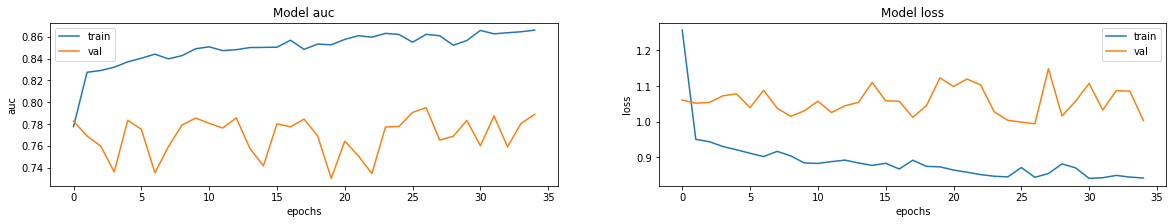

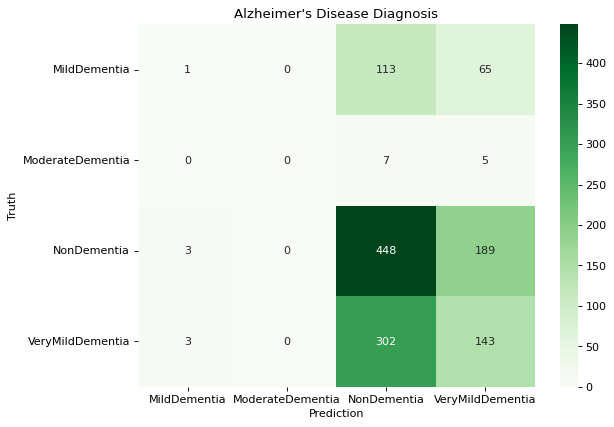

In [14]:
dropout = 0.5

backend.clear_session()
inception_base = InceptionV3(
    weights = 'imagenet', 
    include_top = False,
    input_shape = (*img_size, 3),
    )

inception_base.trainable = False

visible = layers.Input(shape=(250,250,3), name='input')
x = inception_base(visible)
x = layers.Dropout(dropout)(x)

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation = 'relu')(x)
x = layers.Dropout(dropout + 0.1)(x)

output = layers.Dense(4, activation='softmax', name='output')(x)

model = Model(inputs=visible, outputs=output)

model.compile(optimizer = 'adam',
               loss = 'categorical_crossentropy',
               metrics = [metrics.AUC(name='auc')]
             )

history = model.fit( 
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=validation_generator,
    verbose = 1,
    callbacks=[
               EarlyStopping(
                   monitor='val_auc',
                   patience=15,
                   restore_best_weights = True
                   )
               ]
            )

fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()
for i, met in enumerate(['auc', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

test_loss, test_auc = model.evaluate(test_generator)
print()
print('test_auc:', test_auc)

y_prob = model.predict(test_generator)
y_pred = y_prob.argmax(axis=-1)
y_actual = test_generator.classes

print()
print(classification_report(y_actual, y_pred, target_names=class_names))

cm = confusion_matrix(y_actual, y_pred)
plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
ax = sns.heatmap(cm, cmap='Greens', annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.title('Alzheimer\'s Disease Diagnosis')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)

### Results
Using GlobalAveragePooling2D instead of a Flatten layer has produced the highest AUC model so far.

# Deciding on number of layers to freeze
The following is the InceptionV3 block number to layer number mapping:
  + Inception block 1 / layer number 40 / freeze layers till 41 / num trainable blocks 10
  + Inception block 2 / layer number 63 / freeze layers till 64 / num trainable blocks 9
  + Inception block 3 / layer number 86 / freeze layers till 87 / num trainable blocks 8
  + Inception block 4 / layer number 100 / freeze layers till 101 / num trainable blocks 7
  + Inception block 5 / layer number 132 / freeze layers till 133 / num trainable blocks 6
  + Inception block 6 / layer number 164 / freeze layers till 165 / num trainable blocks 5
  + Inception block 7 / layer number 196 / freeze layers till 197 / num trainable blocks 4
  + Inception block 8 / layer number 228 / freeze layers till 228 / num trainable blocks 3
  + Inception block 9 / layer number 248 / freeze layers till 249 / num trainable blocks 2  

So, training the minimum number of layers I would freeze till 249. This is where I will start. However, I am not completely familiar with all the images in Imagenet but there is a good chance Alzheimer's MRI scans aren't very well represented. Because of this I will probably have to open up more trainable layers to learn the data.

# Top 2 Blocks Trainable

Epoch 1/50
128/128 [==============================] - 85s 621ms/step - loss: 0.9661 - auc: 0.8345 - val_loss: 2.8873 - val_auc: 0.7549
Epoch 2/50
128/128 [==============================] - 78s 610ms/step - loss: 0.7779 - auc: 0.8895 - val_loss: 1.4029 - val_auc: 0.7692
Epoch 3/50
128/128 [==============================] - 79s 616ms/step - loss: 0.6878 - auc: 0.9154 - val_loss: 1.8451 - val_auc: 0.6474
Epoch 4/50
128/128 [==============================] - 78s 610ms/step - loss: 0.6040 - auc: 0.9350 - val_loss: 1.0702 - val_auc: 0.8290
Epoch 5/50
128/128 [==============================] - 80s 622ms/step - loss: 0.5431 - auc: 0.9471 - val_loss: 1.3319 - val_auc: 0.7871
Epoch 6/50
128/128 [==============================] - 79s 616ms/step - loss: 0.4780 - auc: 0.9590 - val_loss: 1.2321 - val_auc: 0.7700
Epoch 7/50
128/128 [==============================] - 79s 614ms/step - loss: 0.4440 - auc: 0.9644 - val_loss: 1.1408 - val_auc: 0.8076
Epoch 8/50
128/128 [==============================] - 7

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


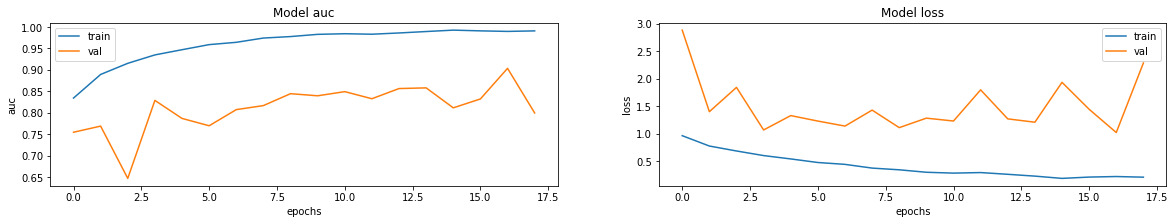

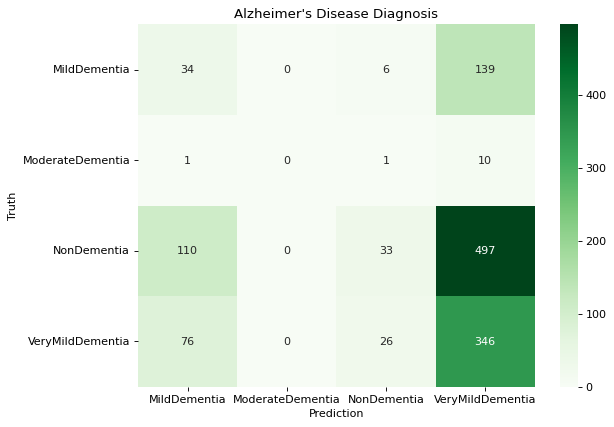

In [15]:
backend.clear_session()

inception_base = InceptionV3(
    weights = 'imagenet', 
    include_top = False,
    input_shape = (*img_size, 3)
    )

for layer in inception_base.layers[:249]:
    layer.trainable = False
for layer in inception_base.layers[249:]:
    layer.trainable = True

visible = layers.Input(shape=(250,250,3), name='input')
x = inception_base(visible)
x = layers.Dropout(dropout)(x)

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation = 'relu')(x)
x = layers.Dropout(dropout + 0.1)(x)

output = layers.Dense(4, activation='softmax', name='output')(x)

model = Model(inputs=visible, outputs=output)

model.compile(optimizer = 'adam',
               loss = 'categorical_crossentropy',
               metrics = [metrics.AUC(name='auc')]
             )

history = model.fit( 
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=validation_generator,
    verbose = 1,
    callbacks=[EarlyStopping(
        monitor='val_auc',
        patience=15,
        restore_best_weights = True
    )
              ]
)

fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()
for i, met in enumerate(['auc', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

test_loss, test_auc = model.evaluate(test_generator)

print()
print('test_auc:', test_auc)

y_prob = model.predict(test_generator)
y_pred = y_prob.argmax(axis=-1)
y_actual = test_generator.classes

print()
print(classification_report(y_actual, y_pred, target_names=class_names))

cm = confusion_matrix(y_actual, y_pred)
plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
ax = sns.heatmap(cm, cmap='Greens', annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.title('Alzheimer\'s Disease Diagnosis')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)

### Results
Training the top two blocks in the Inception V3 model dropped the AUC by almost 20%. It did however get better at classifying mild dementia which the other model didn't do very well.

# Overall Analysis Conclusions
There are a lot of ways you can attack an image classification problem. However, if you don't have the proper training data you will always be limited. In this case, mild and moderate dementia were not very well represented in the data and therefore were not predicted very well. The best models I could produce were predicting non-dementia and very mild dementia with fairly high (0.8+) AUC while hardly predicting the other two classes. It was able to do this because the other two classes were also hardly represented in the test data, so missing the predictions didn't penalize the metric much. With this specfic dataset, it would probably be more pragmatic to pivot to binary classification of dementia vs non-dementia.